# Maternal Health Risk Prediction using Logistic Regression

## Dataset: Maternal Health Risk Dataset (Kaggle)
### Focus: Pregnancy-associated hypertension and pre-eclampsia risk

## 1. Imports and Configuration

In [1]:
# Imports and Configuration
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_validate,cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    recall_score,
    precision_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 2. Data Loading and Initial Inspection

In [2]:
# Load dataset
df = pd.read_csv("data/Maternal Health Risk Data Set.csv")
# Preview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          808 non-null    int64  
 1   SystolicBP   808 non-null    int64  
 2   DiastolicBP  808 non-null    int64  
 3   BS           808 non-null    float64
 4   BodyTemp     808 non-null    float64
 5   HeartRate    808 non-null    int64  
 6   RiskLevel    808 non-null    object 
dtypes: float64(2), int64(4), object(1)
memory usage: 44.3+ KB


## 3. Exploratory Data Analysis (EDA)

### 3.1 Target Variable Encoding and Distribution

In [102]:
# Encode target variable - High risk = 1, Low risk = 0
df["Risk_encoded"] = df["RiskLevel"].apply(lambda x: 1 if x == "high risk" else 0)

X = df.drop(columns=["RiskLevel", "Risk_encoded"])
y = df["Risk_encoded"]

# For reference only (not used in encoding)
le = LabelEncoder()
le.classes_ = np.array(["low risk", "high risk"])  # Manually set classes if needed

# Verify the encoding
print("=== LABEL ENCODING CHECK ===")
print("Original RiskLevel counts:")
print(df["RiskLevel"].value_counts())
print("\nEncoded RiskLevel_encoded counts:")
print(df["Risk_encoded"].value_counts())
print("\nMapping:")
print(f"high risk -> {df[df['RiskLevel'] == 'high risk']['Risk_encoded'].iloc[0]}")
print(f"low risk -> {df[df['RiskLevel'] == 'low risk']['Risk_encoded'].iloc[0]}")

=== LABEL ENCODING CHECK ===
Original RiskLevel counts:
RiskLevel
low risk     478
high risk    330
Name: count, dtype: int64

Encoded RiskLevel_encoded counts:
Risk_encoded
0    478
1    330
Name: count, dtype: int64

Mapping:
high risk -> 1
low risk -> 0


In [121]:
# Class distribution counts
class_counts = df['RiskLevel'].value_counts()

print("\nClass Distribution:")
for label, count in class_counts.items():
    print(f"{label}: {count}")

print("\nClass Distribution (%):")
print((class_counts / class_counts.sum() * 100).round(2))


Class Distribution:
low risk: 478
high risk: 330

Class Distribution (%):
RiskLevel
low risk     59.16
high risk    40.84
Name: count, dtype: float64


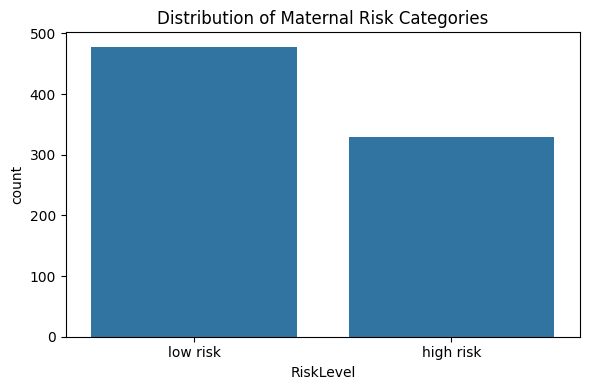

In [122]:
# Class distribution plot
plt.figure(figsize=(6, 4))
# Plot with correct order - use the original RiskLevel column
sns.countplot(x="RiskLevel", data=df, order=["low risk", "high risk"])
plt.title("Distribution of Maternal Risk Categories")
plt.tight_layout()
plt.savefig("figure_Distribuition_of_Maternal_Risk_Categories.png", dpi=300)
plt.show()

### 3.2 Feature Correlations

In [123]:
# Pearson correlation between systolic and diastolic BP 
bp_corr = df[['SystolicBP', 'DiastolicBP']].corr(method='pearson').iloc[0, 1]

print(f"\nPearson correlation between SystolicBP and DiastolicBP: r = {bp_corr:.2f}")



Pearson correlation between SystolicBP and DiastolicBP: r = 0.87


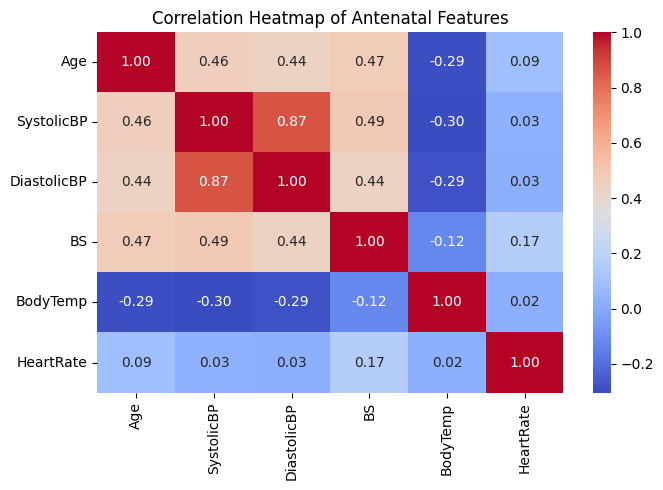

In [107]:
# Correlation analysis
plt.figure(figsize=(7, 5))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Antenatal Features")
plt.tight_layout()
plt.savefig("figure2_correlation_heatmap.png", dpi=300)
plt.show()

### 3.3 Bivariate Analysis (High vs Low Risk Groups)

In [108]:
raw_features = [
    "Age",
    "SystolicBP",
    "DiastolicBP",
    "BS",
    "BodyTemp",
    "HeartRate"
]

from scipy.stats import ttest_ind

bivariate_results = []

for feature in raw_features:
    low = df[df["RiskLevel"] == "low risk"][feature]
    high = df[df["RiskLevel"] == "high risk"][feature]

    t_stat, p_val = ttest_ind(low, high, equal_var=False)

    bivariate_results.append({
        "Feature": feature,
        "LowRisk_Mean": low.mean(),
        "HighRisk_Mean": high.mean(),
        "t_stat": t_stat,
        "p_value": p_val
    })

bivariate_df = pd.DataFrame(bivariate_results)
bivariate_df

,Feature,LowRisk_Mean,HighRisk_Mean,t_stat,p_value
0,Age,26.895397,35.930303,-9.554802,1.998172e-20
1,SystolicBP,105.790795,123.375758,-13.108150,1.119358e-34
2,DiastolicBP,72.546025,84.675758,-12.322798,1.438431e-31
3,BS,7.268473,12.156545,-21.171806,4.392693e-64
4,BodyTemp,98.422176,98.956364,-5.185974,2.997741e-07
5,HeartRate,72.742678,76.548485,-6.152414,1.280948e-09


## 4. Feature Engineering

In [109]:
# Feature Engineering: Mean Arterial Pressure (MAP)
# Create a copy for modeling
cols_to_drop = [col for col in ["RiskLevel", "Risk_encoded"] if col in df.columns]
X = df.drop(columns=cols_to_drop).copy()

# Create MAP
X["MAP"] = (X["SystolicBP"] + 2 * X["DiastolicBP"]) / 3

# Drop original BP columns
X = X.drop(columns=["SystolicBP", "DiastolicBP"])


## 5. Model Development

### 5.1 Cross-Validation Setup

In [124]:
# Model Pipeline and Cross-Validation
logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_results = cross_validate(
    logreg_pipeline,
    X,
    y,
    cv=cv,
    scoring={
        "recall": "recall",
        "precision": "precision",
        "accuracy": "accuracy"
    }
)

print("Logistic Regression CV Metrics (5-fold)")
print(
    "Recall: %.2f ± %.2f"
    % (cv_results["test_recall"].mean(),
       cv_results["test_recall"].std())
)
print(
    "Precision: %.2f ± %.2f"
    % (cv_results["test_precision"].mean(),
       cv_results["test_precision"].std())
)
print(
    "Accuracy: %.2f ± %.2f"
    % (cv_results["test_accuracy"].mean(),
       cv_results["test_accuracy"].std())
)

Logistic Regression CV Metrics (5-fold)
Recall: 0.83 ± 0.06
Precision: 0.89 ± 0.02
Accuracy: 0.89 ± 0.03


### 5.2 Train-Test Split

In [111]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

### 5.3 Model Training

In [112]:
# Logistic Regression Model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="lbfgs"
)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

### 5.4 Model Evaluation

In [113]:
# Threshold Optimization
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

threshold_05 = 0.50
y_pred_05 = (y_prob >= threshold_05).astype(int)

precision_05 = precision_score(y_test, y_pred_05)
recall_05 = recall_score(y_test, y_pred_05)
accuracy_05 = accuracy_score(y_test, y_pred_05)

print("Default Threshold (0.50)")
print("Precision:", round(precision_05, 2))
print("Recall:", round(recall_05, 2))
print("Accuracy:", round(accuracy_05, 2))

threshold_035 = 0.35
y_pred_035 = (y_prob >= threshold_035).astype(int)

precision_035 = precision_score(y_test, y_pred_035)
recall_035 = recall_score(y_test, y_pred_035)
accuracy_035 = accuracy_score(y_test, y_pred_035)

print("\nOptimized Threshold (0.35)")
print("Precision:", round(precision_035, 2))
print("Recall:", round(recall_035, 2))
print("Accuracy:", round(accuracy_035, 2))


comparison_df = pd.DataFrame({
    "Threshold": [0.50, 0.35],
    "Precision": [precision_05, precision_035],
    "Recall": [recall_05, recall_035],
    "Accuracy": [accuracy_05, accuracy_035]
})

comparison_df["Precision"] = comparison_df["Precision"].round(2)
comparison_df["Recall"] = comparison_df["Recall"].round(2)
comparison_df["Accuracy"] = comparison_df["Accuracy"].round(2)

print(comparison_df)

print("\nClassification Report – Threshold 0.50")
print(classification_report(y_test, y_pred_05, target_names=le.classes_))

print("\nClassification Report – Threshold 0.35")
print(classification_report(y_test, y_pred_035, target_names=le.classes_))

Default Threshold (0.50)
Precision: 0.89
Recall: 0.89
Accuracy: 0.91

Optimized Threshold (0.35)
Precision: 0.87
Recall: 0.94
Accuracy: 0.92
   Threshold  Precision  Recall  Accuracy
0       0.50       0.89    0.89      0.91
1       0.35       0.87    0.94      0.92

Classification Report – Threshold 0.50
              precision    recall  f1-score   support

    low risk       0.93      0.93      0.93        96
   high risk       0.89      0.89      0.89        66

    accuracy                           0.91       162
   macro avg       0.91      0.91      0.91       162
weighted avg       0.91      0.91      0.91       162


Classification Report – Threshold 0.35
              precision    recall  f1-score   support

    low risk       0.96      0.91      0.93        96
   high risk       0.87      0.94      0.91        66

    accuracy                           0.92       162
   macro avg       0.91      0.92      0.92       162
weighted avg       0.92      0.92      0.92       162


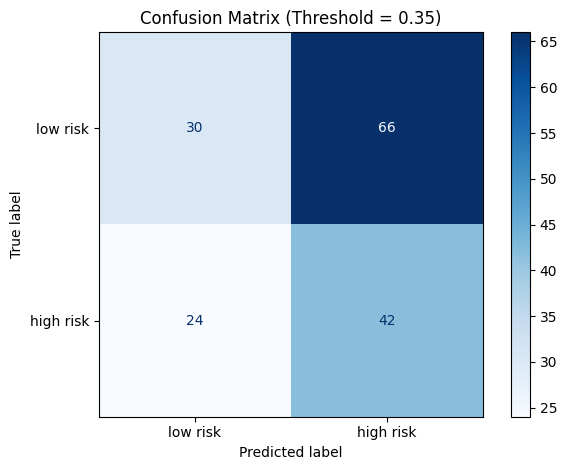

In [115]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_thresh)
disp = ConfusionMatrixDisplay(cm, display_labels=["low risk", "high risk"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Threshold = 0.35)")
plt.tight_layout()
plt.savefig("figure3_Confusion_Matrix.png", dpi=300)
plt.show()

## 6. Model Interpretation

### 6.1 Odds Ratios for Clinical Interpretation

In [116]:
# Odds Ratios for Clinical Interpretation
odds_ratios = pd.DataFrame({
    "Feature": X.columns,
    "Odds_Ratio": np.exp(log_reg.coef_[0])
}).sort_values(by="Odds_Ratio", ascending=False)

print("\nAdjusted Odds Ratios")
print(odds_ratios)


Adjusted Odds Ratios
     Feature  Odds_Ratio
1         BS   27.561743
4        MAP    4.650058
2   BodyTemp    3.503898
3  HeartRate    1.343016
0        Age    0.959812


### 6.2 Model Calibration Analysis

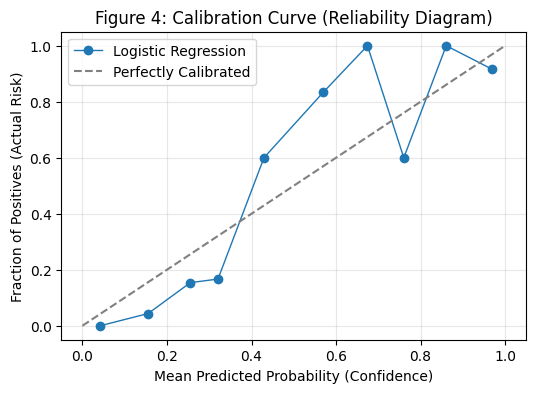

In [134]:
# Calculate the calibration curve data
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

prob_true, prob_pred = calibration_curve(y_test, y_prob_lr, n_bins=10)

# Plotting the Reliability Diagram
plt.figure(figsize=(6, 4))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Logistic Regression')

# Reference line for a perfectly calibrated model
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

plt.xlabel('Mean Predicted Probability (Confidence)')
plt.ylabel('Fraction of Positives (Actual Risk)')
plt.title('Figure 4: Calibration Curve (Reliability Diagram)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.savefig("figure4_calibration_curve.png", dpi=300)
plt.show()

## 7. Comparator Model: Random Forest

### 7.1 Random Forest Model Training

In [117]:
# Comparator Model: Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=RANDOM_STATE,
    class_weight="balanced"
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("\nRandom Forest Performance")
print("Recall:", recall_score(y_test, rf_pred))
print("Precision:", precision_score(y_test, rf_pred))
print("Accuracy:", accuracy_score(y_test, rf_pred))


Random Forest Performance
Recall: 1.0
Precision: 0.9295774647887324
Accuracy: 0.9691358024691358


### 7.2 Random Forest Cross-Validation

In [118]:
# Random Forest 5-fold cross-validation for multiple metrics
rf_cv_recall = cross_val_score(rf, X, y, cv=cv, scoring="recall")
rf_cv_precision = cross_val_score(rf, X, y, cv=cv, scoring="precision")
rf_cv_accuracy = cross_val_score(rf, X, y, cv=cv, scoring="accuracy")

print("\nRandom Forest CV Metrics (5-fold)")
print("Recall: %.2f ± %.2f" % (rf_cv_recall.mean(), rf_cv_recall.std()))
print("Precision: %.2f ± %.2f" % (rf_cv_precision.mean(), rf_cv_precision.std()))
print("Accuracy: %.2f ± %.2f" % (rf_cv_accuracy.mean(), rf_cv_accuracy.std()))


Random Forest CV Metrics (5-fold)
Recall: 0.95 ± 0.02
Precision: 0.96 ± 0.01
Accuracy: 0.96 ± 0.01


## 8. Model Comparison and Analysis

### 8.1 Performance Comparison Between Models

In [119]:
#  Compare Logistic Regression CV vs RF CV to illustrate RF overfitting
# Logistic Regression CV accuracy
logreg_cv_acc = cv_results["test_accuracy"].mean()
print("Logistic Regression CV Accuracy:", logreg_cv_acc)

# Comparison table
comparison_df = pd.DataFrame({
    "Model": ["Logistic Regression (CV)", "Random Forest (Train)", "Random Forest (CV)"],
    "Accuracy": [logreg_cv_acc, rf_train_acc, rf_cv_acc]
})
print("\nModel Accuracy Comparison")
print(comparison_df)

Logistic Regression CV Accuracy: 0.8911356491066635

Model Accuracy Comparison
                      Model  Accuracy
0  Logistic Regression (CV)  0.891136
1     Random Forest (Train)  0.986068
2        Random Forest (CV)  0.964113


### 8.2 Feature Importance Analysis

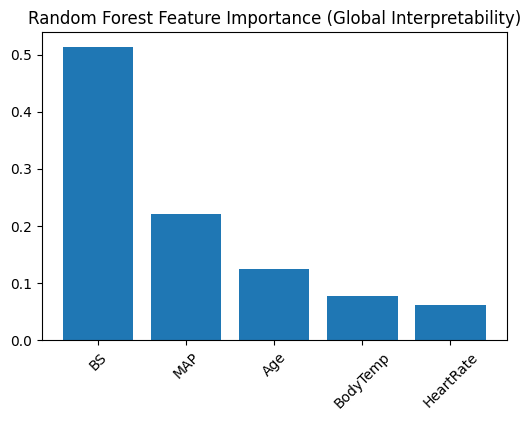

In [133]:
# Train the 'Benchmark' Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Extract Feature Importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

# Plotting 
plt.figure(figsize=(6, 4))
plt.title("Random Forest Feature Importance (Global Interpretability)")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), features[indices], rotation=45)
plt.savefig("figure5_Random_Forest_Feature_Importance_(Global_Interpretability).png", dpi=300)
plt.show()